In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
# 1: non-clustered categories
#2: clustered categories

features_train1 = select('select * from final_cat_features_train')
features_test1 = select('select * from final_cat_features_test')

features_train2 = select('select * from final_cluster_features_train')
features_test2 = select('select * from final_cluster_features_test')

targets_train = select('select * from final_targets_train')
targets_test = select('select * from final_targets_test')

In [5]:
# the alternative feature matrices differ only in how the categorical information is represented. we will use different
# training sets for different algorithms, based on which combinations seem to work best.

print(len(features_train1))
print(len(features_train2))
print(len(targets_train))

print(len(features_test1))
print(len(features_test2))
print(len(targets_test))

201894
201894
201894
50474
50474
50474


In [6]:
# for logistic regression: use SMOTE with 1:1 ratio. use non-clustered categories

LR_ratio = {0:targets_train.loan_status.sum(),
            1:targets_train.loan_status.sum()}

LR_features, LR_targets = SMOTE(ratio=LR_ratio,random_state=2).fit_sample(features_train1,targets_train.loan_status)

In [7]:
# for gaussian naive bayes: use ADASYN with 1:1 ratio. use clustered categories

GNB_ratio = {0:targets_train.loan_status.sum(),
             1:targets_train.loan_status.sum()}

GNB_features, GNB_targets = ADASYN(ratio=GNB_ratio,random_state=3).fit_sample(features_train2,targets_train.loan_status)

In [8]:
# for K-NN: use ADASYN with 1:1 ratio. use clustered categories (use a different random state than GNB)

KNN_ratio = {0:targets_train.loan_status.sum(),
             1:targets_train.loan_status.sum()}

KNN_features, KNN_targets = ADASYN(ratio=KNN_ratio,random_state=4).fit_sample(features_train2,targets_train.loan_status)

In [9]:
# for random forest: use under sampling with 13:10 ratio. use clustered categories

RF_ratio = {0:(-(targets_train-1).loan_status.sum()),
            1:int((-(targets_train-1).loan_status.sum())/(1.3))}

RF_features, RF_targets = RandomUnderSampler(ratio=RF_ratio,random_state=5).fit_sample(features_train2,targets_train.loan_status)

In [10]:
# LR: no hyperparameter adjustment (negligible effects)
# GNB: no hyperparameter adjustment (resampling is already done..this would be redundant)
# k-NN: use 30 neighbors
# RF: use 80 trees

LR = LogisticRegression().fit(LR_features,LR_targets)
GNB = GaussianNB().fit(GNB_features,GNB_targets)
KNN = KNeighborsClassifier(n_neighbors=30).fit(KNN_features,KNN_targets)
RF = RandomForestClassifier(n_estimators=80).fit(RF_features,RF_targets)

In [11]:
# individual performances on their respective training sets (before resampling is applied)

print('LR TRAIN')
print(classification_report(targets_train,LR.predict(features_train1)))
print('GNB TRAIN')
print(classification_report(targets_train,GNB.predict(features_train2)))
print('k-NN TRAIN')
print(classification_report(targets_train,KNN.predict(features_train2)))
print('RF TRAIN')
print(classification_report(targets_train,RF.predict(features_train2)))

LR TRAIN
             precision    recall  f1-score   support

          0       0.28      0.62      0.38     35905
          1       0.89      0.65      0.75    165989

avg / total       0.78      0.64      0.68    201894

GNB TRAIN
             precision    recall  f1-score   support

          0       0.22      0.81      0.34     35905
          1       0.90      0.37      0.52    165989

avg / total       0.78      0.45      0.49    201894

k-NN TRAIN
             precision    recall  f1-score   support

          0       0.27      0.32      0.29     35905
          1       0.85      0.81      0.83    165989

avg / total       0.74      0.72      0.73    201894

RF TRAIN
             precision    recall  f1-score   support

          0       0.33      1.00      0.50     35905
          1       1.00      0.57      0.72    165989

avg / total       0.88      0.64      0.68    201894



In [30]:
# individual performances on the test set, using the respective features (non-clustered for LR, clustered for rest)

print('LR TRAIN')
print(classification_report(targets_test,LR.predict(features_test1)))
print('GNB TRAIN')
print(classification_report(targets_test,GNB.predict(features_test2)))
print('k-NN TRAIN')
print(classification_report(targets_test,KNN.predict(features_test2)))
print('RF TRAIN')
print(classification_report(targets_test,RF.predict(features_test2)))

LR TRAIN
             precision    recall  f1-score   support

          0       0.28      0.64      0.38      8804
          1       0.89      0.64      0.75     41670

avg / total       0.79      0.64      0.69     50474

GNB TRAIN
             precision    recall  f1-score   support

          0       0.21      0.82      0.33      8804
          1       0.90      0.35      0.50     41670

avg / total       0.78      0.43      0.47     50474

k-NN TRAIN
             precision    recall  f1-score   support

          0       0.24      0.31      0.27      8804
          1       0.85      0.80      0.82     41670

avg / total       0.74      0.71      0.72     50474

RF TRAIN
             precision    recall  f1-score   support

          0       0.23      0.77      0.36      8804
          1       0.91      0.47      0.62     41670

avg / total       0.79      0.52      0.57     50474



In [13]:
ensemble_train = pd.DataFrame()

In [14]:
ensemble_train['LR_predict'] = LR.predict(features_train1)
ensemble_train['GNB_predict'] = GNB.predict(features_train2)
ensemble_train['KNN_predict'] = KNN.predict(features_train2)
ensemble_train['RF_predict'] = RF.predict(features_train2)

In [15]:
# predict_proba returns an array of 2d arrays (probability of each class). we don't need both--that is redundant information
# since (each) = (1 - other). take the first (probability of default)

ensemble_train['LR_prob'] = LR.predict_proba(features_train1)[:,0]
ensemble_train['GNB_prob'] = GNB.predict_proba(features_train2)[:,0]
ensemble_train['KNN_prob'] = KNN.predict_proba(features_train2)[:,0]
ensemble_train['RF_prob'] = RF.predict_proba(features_train2)[:,0]

In [32]:
ensemble_train.head()

,LR_predict,GNB_predict,KNN_predict,RF_predict,LR_prob,GNB_prob,KNN_prob,RF_prob,major_vote
0,1,1,0,1,0.243083,0.342829,0.633333,0.1750,1
1,0,0,1,0,0.669480,0.865439,0.266667,0.7125,0
2,1,1,1,1,0.246772,0.023095,0.200000,0.1250,1
3,1,1,1,1,0.253055,0.223870,0.133333,0.2000,1
4,1,1,0,0,0.289317,0.154595,0.600000,0.7625,0


In [16]:

# majority vote. if the vote is tied (2-2), vote positive (not a default)

def f(x):
    if x>1:
        return 1
    else:
        return 0

ensemble_train['major_vote'] = \
    ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

print('Ensemble Majority Vote - Train')
print('')
print(classification_report(targets_train,ensemble_train['major_vote']))
print('accuracy: '+str(accuracy_score(targets_train,ensemble_train['major_vote'])))

Ensemble Majority Vote - Train

             precision    recall  f1-score   support

          0       0.32      0.64      0.43     35905
          1       0.90      0.71      0.79    165989

avg / total       0.80      0.70      0.73    201894

accuracy: 0.695756188891


In [17]:
# majority vote. if the vote is tied (2-2), vote NEGATIVE (default)

# considerable increase in negative recall and drop in positive recall--this is expected
# small decrease in negative precision and increase in positive precision--this is also expected
# (we're loosening the standards for prediction of the negative class and increasing the standard for prediction
# of the positive class)

def f(x):
    if x>2:
        return 1
    else:
        return 0

ensemble_train['major_vote'] = \
    ensemble_train['LR_predict']+ensemble_train['GNB_predict']+ensemble_train['KNN_predict']+ensemble_train['RF_predict']
ensemble_train['major_vote'] = ensemble_train['major_vote'].apply(f)

print('Ensemble Majority Vote - Train')
print('')
print(classification_report(targets_train,ensemble_train['major_vote']))
print('accuracy: '+str(accuracy_score(targets_train,ensemble_train['major_vote'])))

Ensemble Majority Vote - Train

             precision    recall  f1-score   support

          0       0.28      0.88      0.42     35905
          1       0.95      0.50      0.66    165989

avg / total       0.83      0.57      0.62    201894

accuracy: 0.570076376713


In [90]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr = []
fnr = []
threshholds = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1
    
    ensemble_train['joint_prob'] = \
        ensemble_train['LR_prob']*ensemble_train['GNB_prob']*ensemble_train['KNN_prob']*ensemble_train['RF_prob']

    ensemble_train['joint_predict'] = ensemble_train['joint_prob'].apply(g)

    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['joint_predict']).ravel()

    tnr.append(tn/(tn+fp))
    fnr.append(fn/(fn+tp))

In [101]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr_lr = []
fnr_lr = []

tnr_gnb = []
fnr_gnb = []

tnr_knn = []
fnr_knn = []

tnr_rf = []
fnr_rf = []

threshholds = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1

    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['LR_prob'].apply(g)).ravel()
    tnr_lr.append(tn/(tn+fp))
    fnr_lr.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['GNB_prob'].apply(g)).ravel()
    tnr_gnb.append(tn/(tn+fp))
    fnr_gnb.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['KNN_prob'].apply(g)).ravel()
    tnr_knn.append(tn/(tn+fp))
    fnr_knn.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_train, ensemble_train['RF_prob'].apply(g)).ravel()
    tnr_rf.append(tn/(tn+fp))
    fnr_rf.append(fn/(fn+tp))

(-0.05, 1.05)

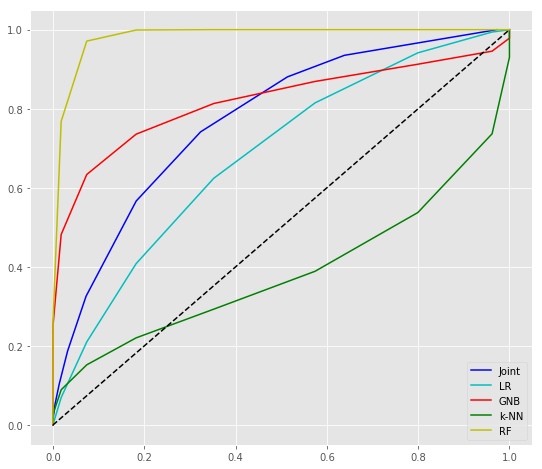

In [105]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

ax.plot(fnr,tnr,'b')
ax.plot(fnr_lr,tnr_lr,'c')
ax.plot(fnr_lr,tnr_gnb,'r')
ax.plot(fnr_lr,tnr_knn,'g')
ax.plot(fnr_lr,tnr_rf,'y')
ax.legend(['Joint','LR','GNB','k-NN','RF'])
ax.plot([0,1],[0,1],'k--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

In [19]:
# now, train classifiers "in sequence" on the predicted probabilities

LR_ensemble = LogisticRegression().fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)
GNB_ensemble = GaussianNB().fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)
KNN_ensemble = KNeighborsClassifier(n_neighbors=30)\
    .fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)
RF_ensemble = RandomForestClassifier(n_estimators=80)\
    .fit(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)

In [20]:
# logistic regression, k-NN, RF all perform extremely well on the training set when running in sequence

print('LR ENSEMBLE TRAIN')
print(classification_report(targets_train,LR_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))
print('GNB ENSEMBLE TRAIN')
print(classification_report(targets_train,GNB_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))
print('KNN ENSEMBLE TRAIN')
print(classification_report(targets_train,KNN_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))
print('RF ENSEMBLE TRAIN')
print(classification_report(targets_train,RF_ensemble.predict(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']])))

LR ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       0.90      0.91      0.91     35905
          1       0.98      0.98      0.98    165989

avg / total       0.97      0.97      0.97    201894

GNB ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       0.65      0.80      0.72     35905
          1       0.95      0.91      0.93    165989

avg / total       0.90      0.89      0.89    201894

KNN ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       0.90      0.93      0.91     35905
          1       0.98      0.98      0.98    165989

avg / total       0.97      0.97      0.97    201894

RF ENSEMBLE TRAIN
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     35905
          1       1.00      1.00      1.00    165989

avg / total       1.00      1.00      1.00    201894



In [21]:
ensemble_test = pd.DataFrame()

In [22]:
# don't bother with majority vote on the test set.
# step 1: develop the probability matrix for input in the next step. use 

ensemble_test['LR_prob'] = LR.predict_proba(features_test1)[:,0]
ensemble_test['GNB_prob'] = GNB.predict_proba(features_test2)[:,0]
ensemble_test['KNN_prob'] = KNN.predict_proba(features_test2)[:,0]
ensemble_test['RF_prob'] = RF.predict_proba(features_test2)[:,0]

In [107]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr = []
fnr = []
threshholds = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1
    
    ensemble_test['joint_prob'] = \
        ensemble_test['LR_prob']*ensemble_test['GNB_prob']*ensemble_test['KNN_prob']*ensemble_test['RF_prob']

    ensemble_test['joint_predict'] = ensemble_test['joint_prob'].apply(g)

    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['joint_predict']).ravel()

    tnr.append(tn/(tn+fp))
    fnr.append(fn/(fn+tp))

In [108]:
# g() defines the decision criteria (threshold) for classifying a default
# ROC w negative instead of positive b/c of labeling choice we took..

tnr_lr = []
fnr_lr = []

tnr_gnb = []
fnr_gnb = []

tnr_knn = []
fnr_knn = []

tnr_rf = []
fnr_rf = []

threshholds = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.02,0.01,0]

for t in threshholds:
    def g(x):
        if x > t:
            return 0
        else:
            return 1

    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['LR_prob'].apply(g)).ravel()
    tnr_lr.append(tn/(tn+fp))
    fnr_lr.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['GNB_prob'].apply(g)).ravel()
    tnr_gnb.append(tn/(tn+fp))
    fnr_gnb.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['KNN_prob'].apply(g)).ravel()
    tnr_knn.append(tn/(tn+fp))
    fnr_knn.append(fn/(fn+tp))
    
    tn, fp, fn, tp = confusion_matrix(targets_test, ensemble_test['RF_prob'].apply(g)).ravel()
    tnr_rf.append(tn/(tn+fp))
    fnr_rf.append(fn/(fn+tp))

(-0.05, 1.05)

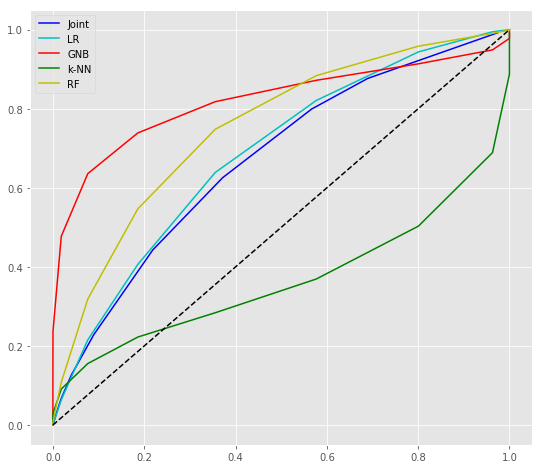

In [109]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

ax.plot(fnr,tnr,'b')
ax.plot(fnr_lr,tnr_lr,'c')
ax.plot(fnr_lr,tnr_gnb,'r')
ax.plot(fnr_lr,tnr_knn,'g')
ax.plot(fnr_lr,tnr_rf,'y')
ax.legend(['Joint','LR','GNB','k-NN','RF'])
ax.plot([0,1],[0,1],'k--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

In [23]:
# not nearly as good performance on the test set.. esp recall again. let's resample one more time.

print('LR ENSEMBLE TEST')
print(classification_report(targets_test,LR_ensemble.predict(ensemble_test),digits=4))
print('GNB ENSEMBLE TEST')
print(classification_report(targets_test,GNB_ensemble.predict(ensemble_test),digits=4))
print('KNN ENSEMBLE TEST')
print(classification_report(targets_test,KNN_ensemble.predict(ensemble_test),digits=4))
print('RF ENSEMBLE TEST')
print(classification_report(targets_test,RF_ensemble.predict(ensemble_test),digits=4))

LR ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.2995    0.0517    0.0882      8804
          1     0.8295    0.9745    0.8961     41670

avg / total     0.7370    0.8135    0.7552     50474

GNB ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.3447    0.2706    0.3031      8804
          1     0.8526    0.8913    0.8715     41670

avg / total     0.7640    0.7830    0.7724     50474

KNN ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.3072    0.0570    0.0962      8804
          1     0.8300    0.9728    0.8958     41670

avg / total     0.7388    0.8131    0.7563     50474

RF ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.2997    0.0546    0.0924      8804
          1     0.8297    0.9730    0.8957     41670

avg / total     0.7372    0.8128    0.7556     50474



In [24]:
final_ratio = {0:((targets_train-1)*-1).loan_status.sum(),
               1:((targets_train-1)*-1).loan_status.sum()}

In [25]:
final_features, final_targets = RandomUnderSampler(ratio=final_ratio)\
    .fit_sample(ensemble_train[['LR_prob','GNB_prob','KNN_prob','RF_prob']],targets_train.loan_status)

In [26]:
# now, train classifiers "in sequence" on the predicted probabilities

LR_ensemble1 = LogisticRegression().fit(final_features,final_targets)
GNB_ensemble1 = GaussianNB().fit(final_features,final_targets)
KNN_ensemble1 = KNeighborsClassifier(n_neighbors=30).fit(final_features,final_targets)
RF_ensemble1 = RandomForestClassifier(n_estimators=80).fit(final_features,final_targets)

In [27]:
# performance is still lagging behind. 

print('LR RESAMPLED ENSEMBLE TEST')
print(classification_report(targets_test,LR_ensemble1.predict(ensemble_test),digits=4))
print('GNB RESAMPLED ENSEMBLE TEST')
print(classification_report(targets_test,GNB_ensemble1.predict(ensemble_test),digits=4))
print('KNN RESAMPLED ENSEMBLE TEST')
print(classification_report(targets_test,KNN_ensemble1.predict(ensemble_test),digits=4))
print('RF RESAMPLED ENSEMBLE TEST')
print(classification_report(targets_test,RF_ensemble1.predict(ensemble_test),digits=4))

LR RESAMPLED ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.3046    0.1230    0.1753      8804
          1     0.8354    0.9407    0.8849     41670

avg / total     0.7429    0.7981    0.7612     50474

GNB RESAMPLED ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.3198    0.3519    0.3351      8804
          1     0.8601    0.8419    0.8509     41670

avg / total     0.7659    0.7564    0.7609     50474

KNN RESAMPLED ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.3115    0.1404    0.1935      8804
          1     0.8373    0.9344    0.8832     41670

avg / total     0.7456    0.7959    0.7629     50474

RF RESAMPLED ENSEMBLE TEST
             precision    recall  f1-score   support

          0     0.3092    0.1153    0.1679      8804
          1     0.8349    0.9456    0.8868     41670

avg / total     0.7432    0.8007    0.7614     50474



In [28]:
# add a majority vote section for the test set?
# add accuracy scores to test set

In [29]:
# the algorithms can find very particular patterns in the training set when using ensembles in sequence, but they do
# not generalize to the test set. again seems to reaffirm that there are not very clear "default patterns"....